<a href="https://colab.research.google.com/github/ZhangEnsure/pytorch-d2l-zh/blob/master/3.%E7%8E%B0%E4%BB%A3%E5%8D%B7%E7%A7%AF%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C/vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l
from torchvision import transforms
import torchvision
from torch.utils import data

# 测试一下副本保存在 github 上

def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    # conv + relu 相同的操作 * num_convs
    # 最后加上一个 MaxPool2d 池化层
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    # 使我们的输出相较输入高、宽减半
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [ ]:
# 在 https://featurize.cn/ 平台上下载数据集至 /featurize/data 目录下
# 本文件位于 /featurize/work/LM 目录下
def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集，然后将其加载到内存中
    Defined in :numref:`sec_fashion_mnist`"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=4),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=4))


In [ ]:
# 参数1指明了 vgg_block 的 num_convs
# 参数2指明了 vgg_block 的 out_channels
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

def vgg(conv_arch):
    conv_blks = []
    # 这里我们使用 Fashion-MNIST 数据集，所以输入通道数目为 1
    in_channels = 1
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    # 在 vgg 的 dense 部分和 AlexNet 网络是一样的
    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

net = vgg(conv_arch)

In [ ]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


In [ ]:
# 我们的数据集不需要太大的通道数，所以这里将通道数进行了缩小
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

In [ ]:
lr, num_epochs, batch_size = 0.05, 10, 128
# 28*28 -> 224*224
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=224)

我们在 featurize 平台斥资 1.4 元体验了一个小时的 3060 来训练。真的好爽，12G 的显存，显卡利用率 90% 左右。真的要努力赚钱哈！

loss 0.178, train acc 0.934, test acc 0.916
1226.3 examples/sec on cuda:0


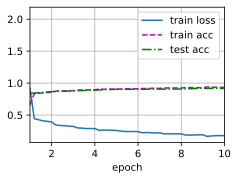

In [ ]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [ ]:
torch.save(net.state_dict(), 'vgg_11.params')